In [1]:
import sys
import os
import json
sys.path.append("..")

import torch
from torch.optim.lr_scheduler import LambdaLR, StepLR
import torch.optim as optim
import random
import numpy as np

from tasks.burgers_1d import Burgers1D
from models.pinns import PINN, SA_PINN, DB_PINN, PirateNetPINN, BasePINN
from models.base_models import ResNet
from models.losses import DWA_Loss
from models.utils.schedulers import LambdaScheduler
from common.train_functions import *
from common.plotting import *

import seaborn as sns

# Init

In [2]:
print("CUDA Version:", torch.version.cuda)
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))

CUDA Version: 12.8
True
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
def save_eval_losses(eval_losses, filename):
    with open(filename, 'w') as f:
        json.dump(eval_losses, f)

def save_u_results(T, X, U, filename):
    with open(filename, 'w') as f:
        json.dump({
            "t_map": T.tolist(), "x_map": X.tolist(), "u_map": U.tolist()
        }, f)

def save_model(model, filename):
    """Save the model's state dictionary to a file."""
    torch.save(model.cpu().state_dict(), filename)

In [4]:
# Fix random number generators
seed = 42
torch.manual_seed(seed)  # For PyTorch
random.seed(seed)        # For random
np.random.seed(seed)     # For NumPy

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
viscosity = 0.0001 / np.pi  # Viscosity
burgers_1d = Burgers1D(nu=viscosity)

In [7]:
# Set number of data points
N_0 = 500
N_b = 500
N_d = 0
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

In [8]:
# Set boundaries
lb = torch.tensor([tmin, xmin], dtype=torch.float32, requires_grad=False)  # Lower bounds
ub = torch.tensor([tmax, xmax], dtype=torch.float32, requires_grad=False)  # Upper bounds

# Generate points for initial conditions
t_0 = torch.ones((N_0, 1), dtype=torch.float32, requires_grad=True) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Compute initial condition at points x_0
u_0 = burgers_1d.initial_conditions(x_0)

# Generate points for boundary conditions
t_b = torch.rand((N_b, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.full((N_b, 1), 0.5, dtype=torch.float32))
x_b.requires_grad_(True)  # Set requires_grad=True for x_b
X_b = torch.cat([t_b, x_b], dim=1)

# Compute boundary condition at points (t_b, x_b)
u_b = burgers_1d.boundary_conditions(t_b)

sobol_sampler = qmc.Sobol(d=2, scramble=True)
X_r = sobol_sampler.random(n=N_r)
X_r = torch.tensor(qmc.scale(X_r, lb, ub), dtype=torch.float32, requires_grad=True)
t_r = X_r[:, 0:1]
x_r = X_r[:, 1:]

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


## Plot generated points

Text(0.5, 1.0, 'Positions of collocation points and boundary data')

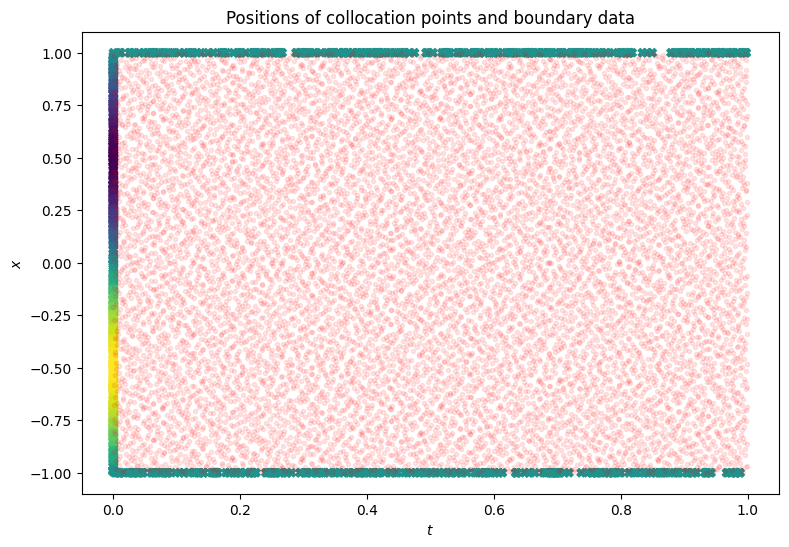

In [9]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0.detach().numpy(), x_0.detach().numpy(), c=u_0.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.detach().numpy(), x_b.detach().numpy(), c=u_b.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.detach().numpy(), x_r.detach().numpy(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
# plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

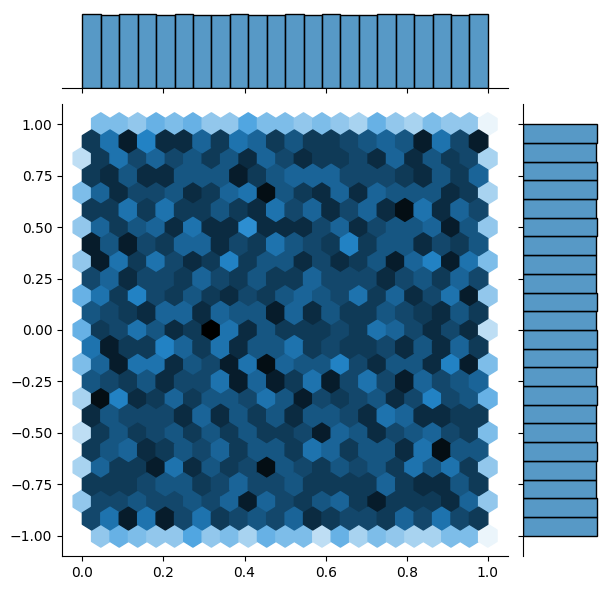

In [10]:
sns.jointplot(
    x=t_r.detach().numpy().flatten(), 
    y=x_r.detach().numpy().flatten(),
    kind="hex",
    
)

plt.show()

# Analytical solution

In [11]:
t_r = np.linspace(tmin, tmax, N_r + 1)
x_r = np.linspace(xmin, xmax, N_r + 1)
T, X = np.meshgrid(t_r, x_r)

In [ ]:
correct = burgers_1d.analytical_solution(T, X)
plot_single_heatmap_2d(T, X, correct, title="Analytical") 

c:\Users\ritka\AI Projects\diploma_pinn\notebooks\..\tasks\burgers_1d.py:62: RuntimeWarning: overflow encountered in exp
  return np.exp(-1 / (2 * self.nu * np.pi) * np.cos(np.pi * y))
c:\Users\ritka\AI Projects\diploma_pinn\notebooks\..\tasks\burgers_1d.py:83: RuntimeWarning: invalid value encountered in scalar multiply
  integrand = lambda y: G(x_val - y, t_val) * phi0(y)
c:\Users\ritka\AI Projects\diploma_pinn\notebooks\..\tasks\burgers_1d.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(integrand, -1, 1, epsabs=1e-10, epsrel=1e-10)
c:\Users\ritka\AI Projec